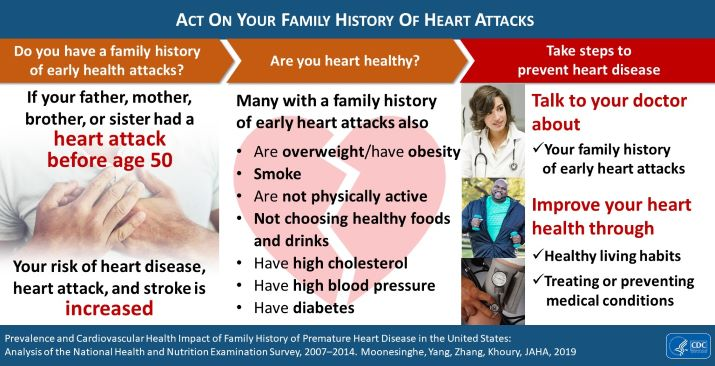

The image above is a refrence image given by the cdc found here https://www.cdc.gov/genomics/visual/visual_abstract.htm.

### Data Info

* Age : Age of the patient
* Sex : Sex of the patient
* cp : Chest Pain type chest pain type
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
    + Value 4: asymptomatic
* trtbps : resting blood pressure (in mm Hg)
* chol : cholestoral in mg/dl fetched via BMI sensor
* exang: exercise induced angina (1 = yes; 0 = no)
* fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* rest_ecg : resting electrocardiographic results
    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach : maximum heart rate achieved
* thalachh: maximum heart rate achieved
* exng: exercise induced angina (1 = yes; 0 = no)
* oldpeak: Previous peak
* slp: Slope
* caa: number of major vessels (0-3)
* thall: Thal rate
* output: 
    + 0= less chance of heart attack 
    + 1= more chance of heart attack

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

from pandas_profiling import ProfileReport
from scipy.stats import shapiro
from scipy.stats import levene
import missingno
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
from collections import Counter
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
heart = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')
df = heart.copy()
df.head()

In [ ]:
def check_df(dataframe, head=5):
    
    print(" SHAPE ".center(70,'#'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'#'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'#'))
    print(dataframe.head(head))
    print(' TAIL '.center(70,'#'))
    print(dataframe.tail(head))
    print(' MISSING VALUES '.center(70,'#'))
    print(dataframe.isnull().sum())
    print(' DUPLICATED VALUES '.center(70,'#'))
    print(dataframe.duplicated().sum())
    print(" QUANTILES ".center(70,'#'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

In [ ]:
desc = df.describe().T
desc_df = pd.DataFrame(index= [col for col in df.columns if df[col].dtype != 'O'], 
                   columns= df.describe().T.columns.tolist(),data= desc )

f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(desc_df, annot=True,cmap = "Blues", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 16})

plt.xticks(size = 18)
plt.yticks(size = 14, rotation = 0)
plt.title("Descriptive Statistics", size = 16)
plt.show()

Map to show corelation between two categories. Darker values mean higher corelation. 

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 15))

df['temp_age'] = (df['age']/5).astype('int')
sns.set(style="darkgrid")

# set the figure size

# top bar -> sum all values to find y position of the bars
df1 = df.groupby(['temp_age'])['sex'].count().reset_index(name = 'count')
dff = df[df.sex == 0].groupby(['temp_age'])['sex'].count().reset_index(name = 'count')
age = df1.merge(dff, on='temp_age', how='outer').fillna(0)
age['temp_age'] =  age['temp_age'].apply(lambda x:str(x*5) + "-" + str((x+1)*5 - 1))

df['temp_trtbps'] = (df['trtbps']/10).astype('int')
df1 = df.groupby(['temp_trtbps'])['sex'].count().reset_index(name = 'count')
dff = df[df.sex == 0].groupby(['temp_trtbps'])['sex'].count().reset_index(name = 'count')
resting_bp = df1.merge(dff, on='temp_trtbps', how='outer').fillna(0)
resting_bp['temp_trtbps'] =  resting_bp['temp_trtbps'].apply(lambda x:str(x*10) + "-" + str((x+1)*10 - 1))

df['temp_chol'] = (df['chol']/40).astype('int')
df1 = df.groupby(['temp_chol'])['sex'].count().reset_index(name = 'count')
dff = df[df.sex == 0].groupby(['temp_chol'])['sex'].count().reset_index(name = 'count')
chol = df1.merge(dff, on='temp_chol', how='outer').fillna(0)
chol['temp_chol'] =  chol['temp_chol'].apply(lambda x:str(x*40) + "-" + str((x+1)*40 - 1))

df['temp_thalachh'] = (df['thalachh']/15).astype('int')
df1 = df.groupby(['temp_thalachh'])['sex'].count().reset_index(name = 'count')
dff = df[df.sex == 0].groupby(['temp_thalachh'])['sex'].count().reset_index(name = 'count')
maxBP = df1.merge(dff, on='temp_thalachh', how='outer').fillna(0)
maxBP['temp_thalachh'] =  maxBP['temp_thalachh'].apply(lambda x:str(x*15) + "-" + str((x+1)*15 - 1))

# bar chart 1 -> top bars 1
bar1 = sns.barplot(x = "temp_age", y = 'count_x', data=age, ax=ax[0][0],color='darkblue')

# bar chart 1 -> bottom bars (group of 'sex=0')
bar2 = sns.barplot(x="temp_age", y= 'count_y', data=age, ax=ax[0][0], estimator=sum, ci=None,  color='lightblue')

# bar1 chart 2
bar1 = sns.barplot(x = "temp_chol", y = 'count_x', data=chol, ax=ax[0][1], color='darkblue')

# bar chart 2 -> bottom bars (group of 'sex=0')
bar2 = sns.barplot(x="temp_chol", y= 'count_y', data=chol, ax=ax[0][1], estimator=sum, ci=None,  color='lightblue')

# bar1 chart 2
bar1 = sns.barplot(x = "temp_trtbps", y = 'count_x', data=resting_bp, ax=ax[1][0], color='darkblue')

# bar chart 2 -> bottom bars (group of 'sex=0')
bar2 = sns.barplot(x="temp_trtbps", y= 'count_y', data=resting_bp, ax=ax[1][0], estimator=sum, ci=None,  color='lightblue')

# bar1 chart 2
bar1 = sns.barplot(x = "temp_thalachh", y = 'count_x', data=maxBP, ax=ax[1][1], color='darkblue')

# bar chart 2 -> bottom bars (group of 'sex=0')
bar2 = sns.barplot(x="temp_thalachh", y= 'count_y', data=maxBP, ax=ax[1][1], estimator=sum, ci=None,  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='Male')
bottom_bar = mpatches.Patch(color='lightblue', label='Female')
ax[0][0].legend(handles=[top_bar, bottom_bar])
ax[0][0].set_title("Age vs Sex Plot")
ax[0][0].set_xlabel("Age")
ax[0][0].set_ylabel("Count")
ax[0][1].legend(handles=[top_bar, bottom_bar])
ax[0][1].set_title("Cholesterol vs Sex Plot")
ax[0][1].set_xlabel("Cholesterol (mg/dl)")
ax[0][1].set_ylabel("Count")
ax[1][0].legend(handles=[top_bar, bottom_bar])
ax[1][0].set_title("Resting BP vs Sex Plot")
ax[1][0].set_xlabel("Resting Bp (mm Hg)")
ax[1][0].set_ylabel("Count")
ax[1][1].legend(handles=[top_bar, bottom_bar])
ax[1][1].set_title("Max BP vs Sex Plot")
ax[1][1].set_xlabel("Max BP (mm Hg)")
ax[1][1].set_ylabel("Count")

fig.suptitle("Gender VS Quantitative Data", fontsize=18)

# show the graph
plt.show()

df.drop(columns = ['temp_age','temp_trtbps','temp_chol','temp_thalachh'], inplace = True)

### Observations
1. There are more males in this dataset
2. There are more males with a lower resting blood pressure than females
3. The resting blood pressure is right skewed with a mean of 132
4. There are more females with a higher cholesterol level than males
5. The max bp is left skewed with a mean of 150

In [ ]:
sns.set_style("white")
matrix = np.triu(df.corr(method="pearson"))
f,ax=plt.subplots(figsize = (15,15))
x_axis_labels = ['age','sex','chest pain type','resting blood pressure','cholestoral','if fasting blood sugar > 120','resting electrocardiographic results','max heart rate','exercise induced angina','previous peak','slope','number of major vessels','thal rate','chance of heart attack']
y_axis_labels = ['age','sex','chest pain type','resting blood pressure','cholestoral','if fasting blood sugar > 120','resting electrocardiographic results','max heart rate','exercise induced angina','previous peak','slope','number of major vessels','thal rate','chance of heart attack']
sns.heatmap(df.corr(),xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot= True,fmt = ".2f",ax=ax,
            vmin = -1, vmax = 1, mask = matrix, cmap = "Blues",
            linewidth = 0.4,linecolor = "white",annot_kws={"size": 12})
plt.xticks(rotation=90,size=10)
plt.yticks(rotation=0,size=10)
plt.title('Pearson Correlation Map', size = 14)
plt.show()

The correlation between the change of a heart attack and a higher max heart rate is 0.42. The data suggests that a higher max heart rate causes heart attacks. 

In [ ]:
sub_df = ['age','sex','caa','trtbps','chol','thalachh','output']
sns.pairplot(df[sub_df],height=5)

In [ ]:
data = go.Scatter3d(x = df['age'],y = df['trtbps'],z = df['chol'],
                    mode='markers',text=df['output'], marker=dict(color=df['output'],size=7,
                                                colorscale='Blues',showscale=False,opacity=0.65))

layout = go.Layout(title=dict(text='Age - trtbps - chol',y=0.9,x=0.5,xanchor= 'center',yanchor= 'top'),
                   scene = dict(xaxis = dict(title='Age'),
                                yaxis = dict(title = 'trtbps'),
                                zaxis = dict(title='chol')),template='plotly_dark')

fig = go.Figure(data=data,layout=layout)
iplot(fig)